In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from models import Encoder, Decoder, NeuroDataset
from itertools import combinations
from utils import calc_gradient_magnitude
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns
from IPython.core.debugger import set_trace

In [2]:
spikes_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data.csv", index_col=0)
spikes_events_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data_spikes.csv", index_col=0) 
print('n_steps', 'n_electrodes', spikes_df.shape)
trim=50
spikes_df = spikes_df[trim:-trim]
spikes_events_df = spikes_events_df[trim:-trim]

n_steps n_electrodes (18775, 556)


In [3]:
X_neural = spikes_df.iloc[:,7:].to_numpy()
X_neural_std = StandardScaler().fit_transform(X_neural)
time = spikes_df['time_s'].values
N = len(time)
n_neurons = X_neural.shape[1]
events = spikes_events_df.values[:,1:].astype(bool)

In [4]:
embedding =  np.load('./embeddings/AE1024_dim-18_ep-700_MSE_TARGETS-xyav-signed.npy')
embedding_torch = torch.from_numpy(embedding).float().cuda()

# Visualization

In [5]:
# from scipy.ndimage import gaussian_filter1d

In [6]:
# N = 5000
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(36,36))
# for i,ax in enumerate(axes.flatten()):
#     e_i = embedding[:,i][:N]
#     e_i_gauss = gaussian_filter1d(e_i, 20)
#     ax.plot(e_i, alpha=0.5)
#     ax.plot(e_i_gauss)
# plt.tight_layout()
# plt.show()

In [7]:
# sns.heatmap(np.corrcoef(embedding.T))
# plt.show()

# Latent model

In [8]:
class NueroLSTM(nn.Module):
    
    def __init__(self, 
                 input_size, 
                 out_size, 
                 hidden_size, 
                 num_layers, 
                 use_attention=False, 
                 dropout=0., 
                 dt=None, 
                 add_1dconv=False, 
                 dim_1dconv=64,
                 kernel_size=5,
                 dilation=1,
                 separate_lstm_per_dim=False):
        
        super().__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_attention = use_attention
        self.dropout = dropout
        self.dt = dt
        self.add_1dconv = add_1dconv
        self.dim_1dconv = dim_1dconv
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.separate_lstm_per_dim = separate_lstm_per_dim 
        if separate_lstm_per_dim:
            self.lstm = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) \
                                       for i in range(self.out_size)])
            self.linear_hidden2one = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU())\
                                                   for i in range(self.out_size)])
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if self.add_1dconv:
            linear_in_size = hidden_size + dim_1dconv
        elif self.separate_lstm_per_dim:
            linear_in_size = out_size
        else:
            linear_in_size = hidden_size
        
        self.linear = nn.Linear(linear_in_size, out_size)
        
        
        if self.add_1dconv:
            kernel_size = self.kernel_size
            dilation = self.dilation
            kernel_size_eff = kernel_size + (kernel_size-1)*(dilation-1)
            conv_layers = []
            current_dim = self.dt
            in_planes = input_size
            while current_dim > 1:
                if current_dim <= kernel_size_eff:
                    kernel_size = current_dim
                    dilation = 1
                    padding = 0
                    maxpool = False
                    current_dim = 1
                else:
                    padding = kernel_size_eff//2 
                    current_dim = current_dim//2
                    maxpool = True
                conv_layers.append(nn.BatchNorm1d(in_planes))
                conv_layers.append(nn.Conv1d(in_planes, dim_1dconv, kernel_size, padding=padding, dilation=dilation))
                if maxpool:
                    conv_layers.append(nn.MaxPool1d(2,2))
                conv_layers.append(nn.LeakyReLU())
                in_planes = dim_1dconv
                
            conv_layers.append(nn.Conv1d(dim_1dconv, dim_1dconv, 1))    
            self.conv1d_block = nn.Sequential(*conv_layers)
            self.last_bn = nn.BatchNorm1d(dim_1dconv + hidden_size)
            
    
    def forward(self, sequence, hidden=None):
        if self.separate_lstm_per_dim:
            out = []
            hidden_out = []
            for i,(lstm, linear) in enumerate(zip(self.lstm, self.linear_hidden2one)):
                out_l, hidden_l = lstm(sequence, hidden[i]) if hidden is not None else lstm(sequence)
                out_l = linear(out_l[:,-1])
                out.append(out_l)
                hidden_out.append(hidden_l)
            out = torch.cat(out, -1)
        else:
            out, hidden_out = self.lstm(sequence, hidden) if hidden is not None else self.lstm(sequence)
            out = out[:,-1]
        
        if self.add_1dconv:
            out_cnn = self.conv1d_block(sequence.transpose(2,1)).squeeze(-1)
            out = torch.cat([out, out_cnn],1)
            out = self.last_bn(out)
            
        out = self.linear(out)
        return out, hidden_out

In [9]:
class SequentialDataloader(Dataset):
    '''
    Returns sequential  
    '''
    def __init__(self, data, target=None, dt=10, dt_target=1):
        
        super().__init__()
        self.dt = dt
        self.dt_target = dt_target
        self.target = target
        self.use_target = target is not None
        if not isinstance(data, torch.Tensor):
            self.data_tensor = torch.from_numpy(data)
        else:
            self.data_tensor = data
        
    def __getitem__(self,i):
        data = self.data_tensor[i:i+self.dt]
        if self.use_target:
            target = self.target[i+self.dt]
        else:
            target = self.data_tensor[i+self.dt:i+self.dt+self.dt_target]
        return data, target

    def __len__(self):
        return self.data_tensor.shape[0] - self.dt - self.dt_target

In [10]:
def seq_n_step_predict(model, initial_seq, n_steps_predict, fresh_start=False):
    results = []
    seq = initial_seq
    hidden_out = None
    for i in range(n_steps_predict):
        if fresh_start:
            seq = initial_seq[:,i:i+model.dt]
        out, hidden_out = model(seq, hidden_out)
        results.append(out)
        if not fresh_start:
            seq = torch.cat([seq[:,1:],out.unsqueeze(1)], dim=1)
    return torch.stack(results, 1)

In [11]:
def validate(model, val_loader, criterion, n_steps_predict_loss):
    model.eval()
    history = defaultdict(list)
    with torch.no_grad():
        for itr, (seq, target) in enumerate(val_loader):  
            
            before_target = seq[:,-1,...].detach()
            before_target = before_target.unsqueeze(1).repeat(1,n_steps_predict_loss,1)
            
            out = seq_n_step_predict(nlstm, seq, n_steps_predict_loss)
            mae = torch.norm(out - target, dim=-1, p=1)
            loss = (mae.mean(0) * time_weights).mean()
            
            MAE = torch.norm(out - target, p=1, dim=-1) / torch.norm(target, p=1, dim=-1)
            MAE = MAE.mean()
            
            history['total_loss'].append(loss.item())
            history['MAE'].append(MAE.item())
            
            MAE_norm_diff = torch.norm(before_target - target, p=1, dim=-1) / torch.norm(target, p=1, dim=-1)
            MAE_norm_diff = MAE_norm_diff.mean()
            
            history['MAE_diff'].append(MAE_norm_diff.item())
    
    history = {k:np.mean(v) for k,v in history.items()}
    return history

# Regression embedding

In [12]:
dt = 100
plot=True
clip_grads= False
fresh_start=True
n_steps_predict = 100
n_steps_predict_loss = 10
epochs = 1000
batch_size = 256
criterion = nn.MSELoss()

In [13]:
N, code_dim = embedding.shape
train_ratio = 0.9
split_index = int(train_ratio*N)

embedding_train = embedding_torch[:split_index]
embedding_val = embedding_torch[split_index:]   

dataset_seq_train = SequentialDataloader(embedding_train, dt=dt, dt_target=n_steps_predict_loss)
dataloader_seq_train = DataLoader(dataset_seq_train, batch_size=batch_size, shuffle=True)

dataset_seq_val = SequentialDataloader(embedding_val, dt=dt, dt_target=n_steps_predict_loss)
dataloader_seq_val = DataLoader(dataset_seq_val, batch_size=batch_size, shuffle=False)

time_weights = torch.tensor([1./(i**2) for i in range(1,n_steps_predict_loss+1)]).cuda()

In [14]:
embedding_train.shape, embedding_val.shape

(torch.Size([16807, 18]), torch.Size([1868, 18]))

In [15]:
for seq, target in dataloader_seq_train:
    break
seq.shape, target.shape

(torch.Size([256, 100, 18]), torch.Size([256, 10, 18]))

In [16]:
nlstm = NueroLSTM(code_dim, 
                  code_dim, 
                  hidden_size=8, 
                  num_layers=1, 
                  dropout=0.0, 
                  dt=dt, 
                  add_1dconv=False, 
                  separate_lstm_per_dim=True).cuda()

optimizer_seq = torch.optim.Adam(nlstm.parameters())

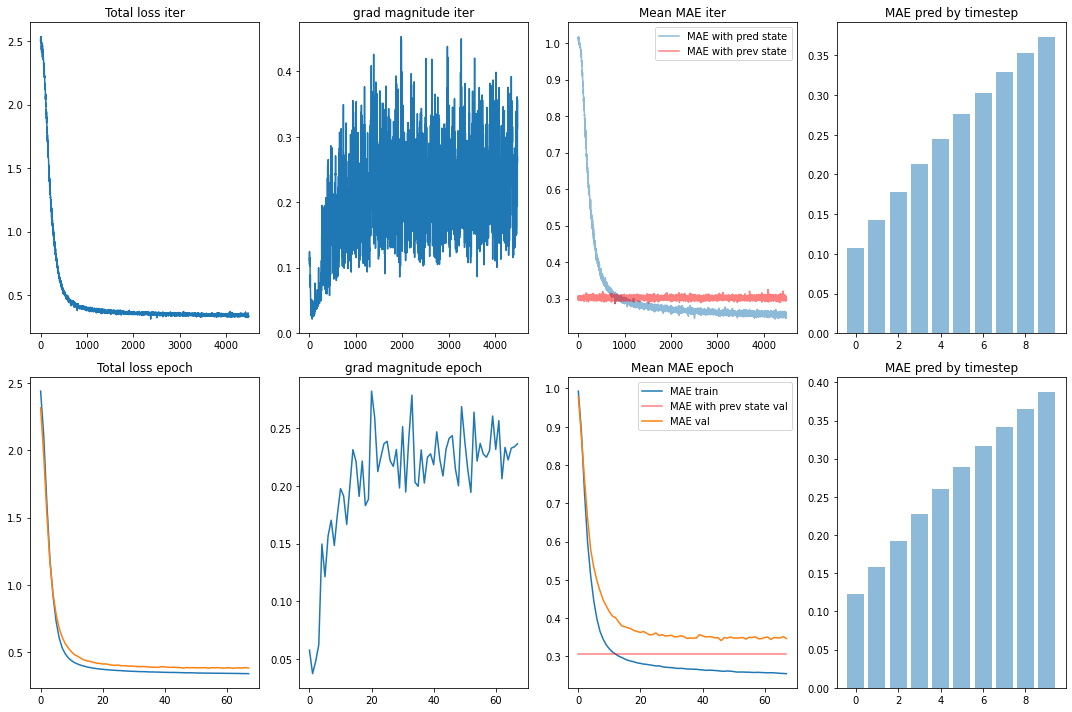

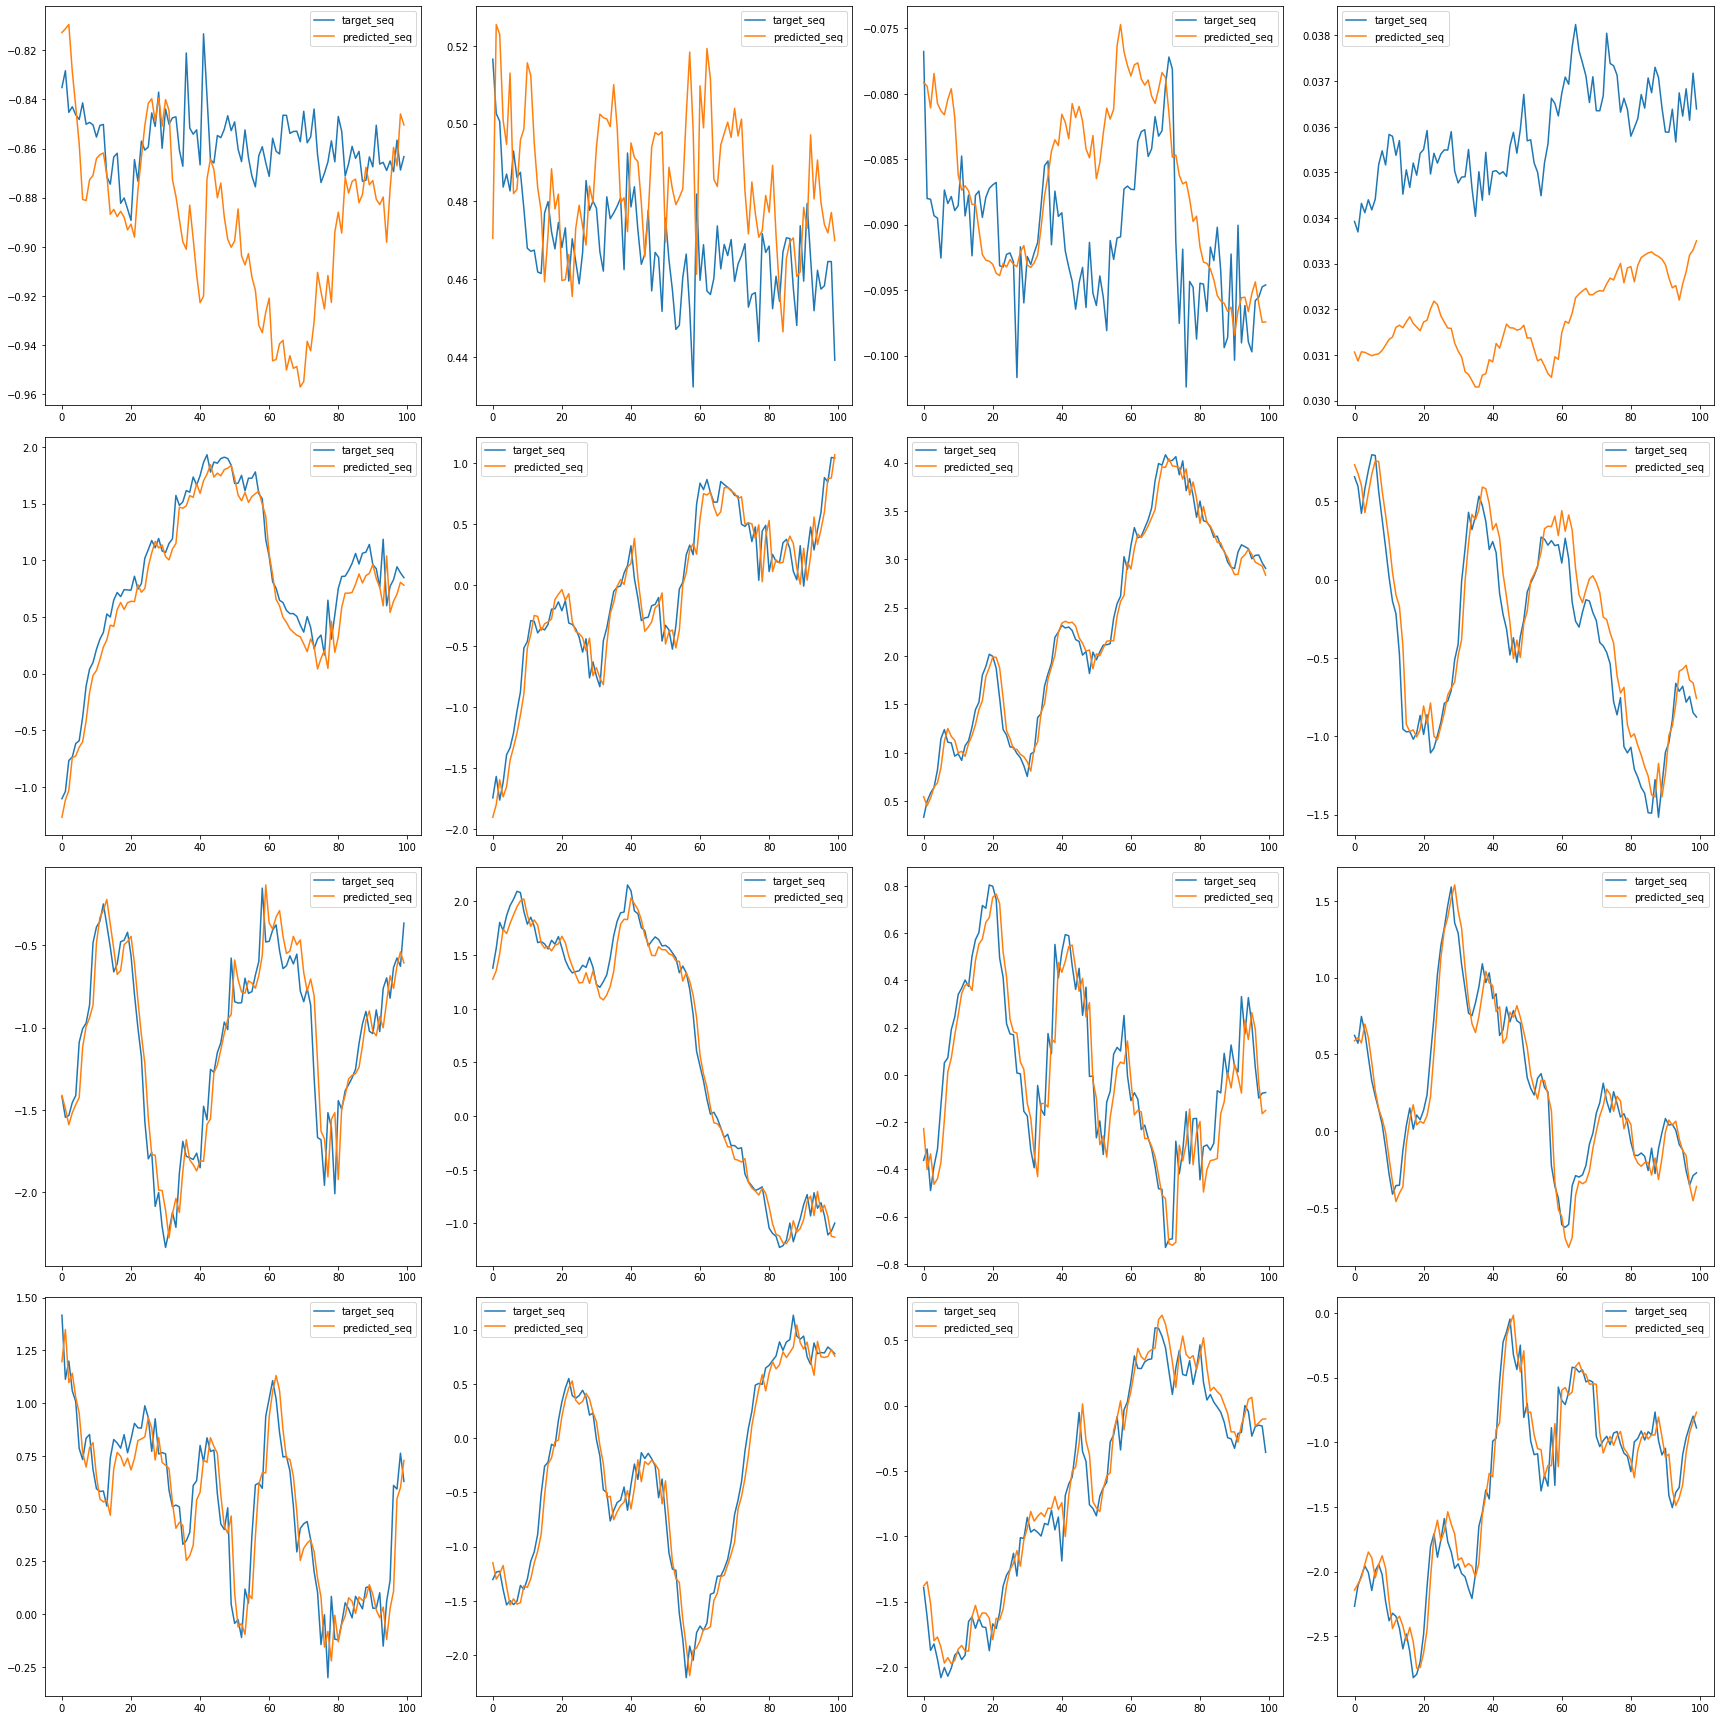

/media/hpc2_storage/ibulygin/miniconda3/envs/mink/lib/python3.7/site-packages/torch/autograd/anomaly_mode.py:70: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  warnings.warn('Anomaly Detection has been enabled. '


KeyboardInterrupt: 

In [17]:
history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in range(epochs):
    for itr, (seq, target) in enumerate(dataloader_seq_train): 
        
        nlstm.train()
        optimizer_seq.zero_grad()
        
        seq = seq.cuda()
        target = target.cuda()
        before_target = seq[:,-1,...].detach()
        before_target = before_target.unsqueeze(1).repeat(1,n_steps_predict_loss,1)
        
        with torch.autograd.detect_anomaly():
            out = seq_n_step_predict(nlstm, seq, n_steps_predict_loss, fresh_start=False)
            mae = torch.norm(out - target, dim=-1, p=1)
            train_loss = (mae.mean(0) * time_weights).mean()
            train_loss.backward()
            
            # metrics
            if clip_grads:
                MAX_GRAD = 1
                torch.nn.utils.clip_grad_value_(nlstm.parameters(), MAX_GRAD)
                assert max([param.grad.abs().max().item() for param in nlstm.parameters()]) <= MAX_GRAD
            
            grad_magnitude = calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                                  nlstm.named_parameters()), silence=False)
            
            MAE_norm = mae / torch.norm(target, p=1, dim=-1)
            MAE_norm = MAE_norm.mean(0).detach()
            
            MAE_norm_diff = torch.norm(before_target - target, p=1, dim=-1) / torch.norm(target, p=1, dim=-1)
            MAE_norm_diff = MAE_norm_diff.mean()
            
            # perform parameter update based on current gradients
            optimizer_seq.step()

        history_train['total_loss'].append(train_loss.item())
        history_train['MAE_by_time'].append([MAE_norm[i].item() for i in range(n_steps_predict_loss)])
        history_train['MAE'].append(MAE_norm.mean().item())
        history_train['MAE_diff'].append(MAE_norm_diff.item())
        history_train['grad_magnitude'].append(grad_magnitude)
        
        if (itr%100) == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,10))
            
            #--------TRAIN
            axes[0,0].plot(history_train['total_loss'])
            axes[0,0].set_title(f'Total loss iter')

            axes[0,1].plot(history_train['grad_magnitude'])
            axes[0,1].set_title(f'grad magnitude iter')
            
            axes[0,2].plot(history_train['MAE'], label=f'MAE with pred state',alpha=0.5)
            axes[0,2].plot(history_train['MAE_diff'], label='MAE with prev state',alpha=0.5, color='r')
            axes[0,2].set_title(f'Mean MAE iter')
            axes[0,2].legend()
            
            axes[0,3].bar(range(n_steps_predict_loss),
                          history_train['MAE_by_time'][-1], 
                          label='MAE_by_time_epoch',
                          alpha=0.5)
            axes[0,3].set_title(f'MAE pred by timestep')
            
            #----------EPOCH
            if epoch > 0:
                axes[1,0].plot(history_train['total_loss_epoch'], label='train')
                axes[1,0].plot(history_val['total_loss'], label='val')
                axes[1,0].set_title(f'Total loss epoch')

                axes[1,1].plot(history_train['grad_magnitude_epoch'], label='train')
                axes[1,1].set_title(f'grad magnitude epoch')

                axes[1,2].plot(history_train['MAE_epoch'], label='MAE train')
                axes[1,2].plot(history_val['MAE_diff'], label='MAE with prev state val',alpha=0.5, color='r')
                axes[1,2].plot(history_val['MAE'], label='MAE val')
                axes[1,2].set_title(f'Mean MAE epoch')
                axes[1,2].legend()


                axes[1,3].bar(range(n_steps_predict_loss),
                              history_train['MAE_by_time_epoch'][-1], 
                              label='MAE_by_time_epoch', 
                              alpha=0.5)
                axes[1,3].set_title(f'MAE pred by timestep')
                plt.tight_layout()
            
            # show discrepancy
            nlstm.eval()
            fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24,24))
            
            start_index = np.random.choice(np.arange(embedding_val.shape[0] - n_steps_predict - dt))
            initial_seq = embedding_val[start_index:start_index+dt+n_steps_predict] if fresh_start else embedding_val[start_index:start_index+dt]
            target_seq = embedding_val[start_index+dt:start_index+dt+n_steps_predict].detach().cpu().numpy()
            with torch.no_grad():
                predicted_seq = seq_n_step_predict(nlstm, initial_seq.unsqueeze(0), n_steps_predict, fresh_start=fresh_start)[0].detach().cpu().numpy()
            for i,ax in enumerate(axes.flatten()):
                ax.plot(target_seq[:,i], label='target_seq')
                ax.plot(predicted_seq[:,i], label='predicted_seq')
                ax.legend()
            plt.tight_layout()
            plt.show()


    # END of the epoch
    history_train['total_loss_epoch'].append(np.mean(history_train['total_loss'][-len(dataloader_seq_train):]))
    history_train['MAE_epoch'].append(np.mean(history_train[f'MAE'][-len(dataloader_seq_train):]))
    history_train['MAE_by_time_epoch'].append([np.mean([history_train['MAE_by_time'][-i][t] for i in range(len(dataloader_seq_train))]) \
                                               for t in range(n_steps_predict_loss)]) 
    history_train['grad_magnitude_epoch'].append(np.mean(history_train['grad_magnitude'][-len(dataloader_seq_train):]))    
    
    history_val_item = validate(nlstm, dataloader_seq_val, criterion, n_steps_predict_loss)
    for k,v in history_val_item.items():
        history_val[k].append(v)

# Predictions from embeddings

In [23]:
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [18]:
targets = np.load('Targets_xyva_signed_CA1_22_1D.npy', allow_pickle=True).item()
nlstm = NueroLSTM(code_dim, 
                  code_dim, 
                  hidden_size=32, 
                  num_layers=1, 
                  dropout=0.0, 
                  dt=dt, 
                  add_1dconv=False, 
                  separate_lstm_per_dim=False).cuda()
weights = torch.load('./NLSTM32_layer1_dt100_nsteps10_epochs1000_bs256_codedim18/weights.pth')
nlstm.load_state_dict(weights)

<All keys matched successfully>

In [19]:
# # coords
# coords = spikes_df[['x', 'y']].values
# coords -= coords.mean(0)[None,:]
# minmax_scaler = MinMaxScaler((-1,1))
# coords_ = minmax_scaler.fit_transform(coords)
# phi = np.arctan2(coords_[:,0], coords_[:,1])

# # speed sign
# dphi = phi - np.concatenate([phi[0:1],phi[:-1]], axis=0)
# dphi[dphi > 6] = -dphi[dphi > 6]
# circle_sign = np.sign(dphi)

# # speed
# shift = coords_ - np.concatenate([coords_[0:1,:],coords_[:-1,:]], axis=0)
# speed = (shift**2).sum(1) * circle_sign

# # acceleration
# speed_shift = np.concatenate(([speed[0]], speed))[:-1]
# acceleration = speed - speed_shift

# acceleration_ = MinMaxScaler((-1,1)).fit_transform(acceleration[:,None]).flatten()
# speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

# targets = {
#     'x': coords_[:,0],
#     'y': coords_[:,1],
#     'v': speed_,
#     'a': acceleration_
# }

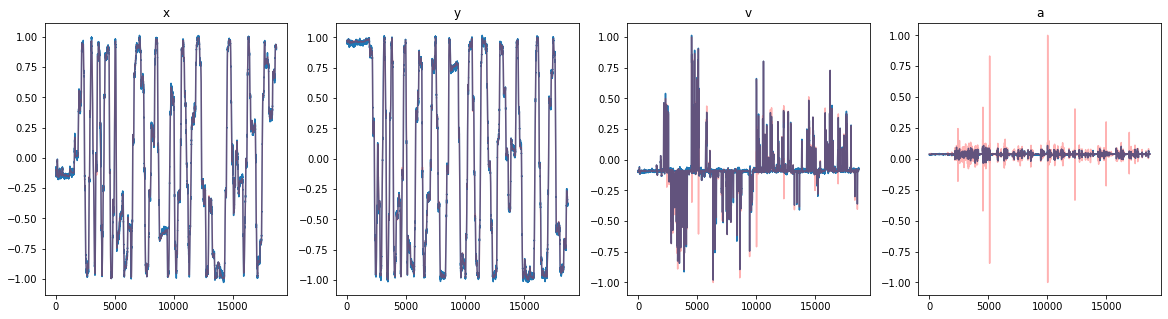

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,5))
for i,(k,v) in enumerate(targets.items()):
    axes[i].plot(embedding[:,i])
    axes[i].plot(v, 'r', alpha=0.3)
    axes[i].set_title(k)

In [24]:
trained_regressors = {}
data_numpy = embedding_train.detach().cpu().numpy()

r2_scorer = make_scorer(r2_score)
model = LGBMRegressor(random_state=42)
# shuffle
N = data_numpy.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)

data_numpy_shuffled = data_numpy[indexes]

for k,v in tqdm_notebook(targets.items()):
    target_shuffled = v[:split_index][indexes] 
    cv_results = cross_val_score(model, data_numpy_shuffled, target_shuffled, cv=10, verbose=False, scoring=r2_scorer)
    print(f'For {k}', cv_results.mean(), cv_results.std())
    trained_regressors[k] = model.fit(data_numpy_shuffled, target_shuffled)


For x 0.9997674350513679 1.0592436738512794e-05
For y 0.999840083663974 8.217607378217978e-06
For v 0.9887114728112678 0.008404764025035878
For a 0.3169212756167272 0.21329930485168838



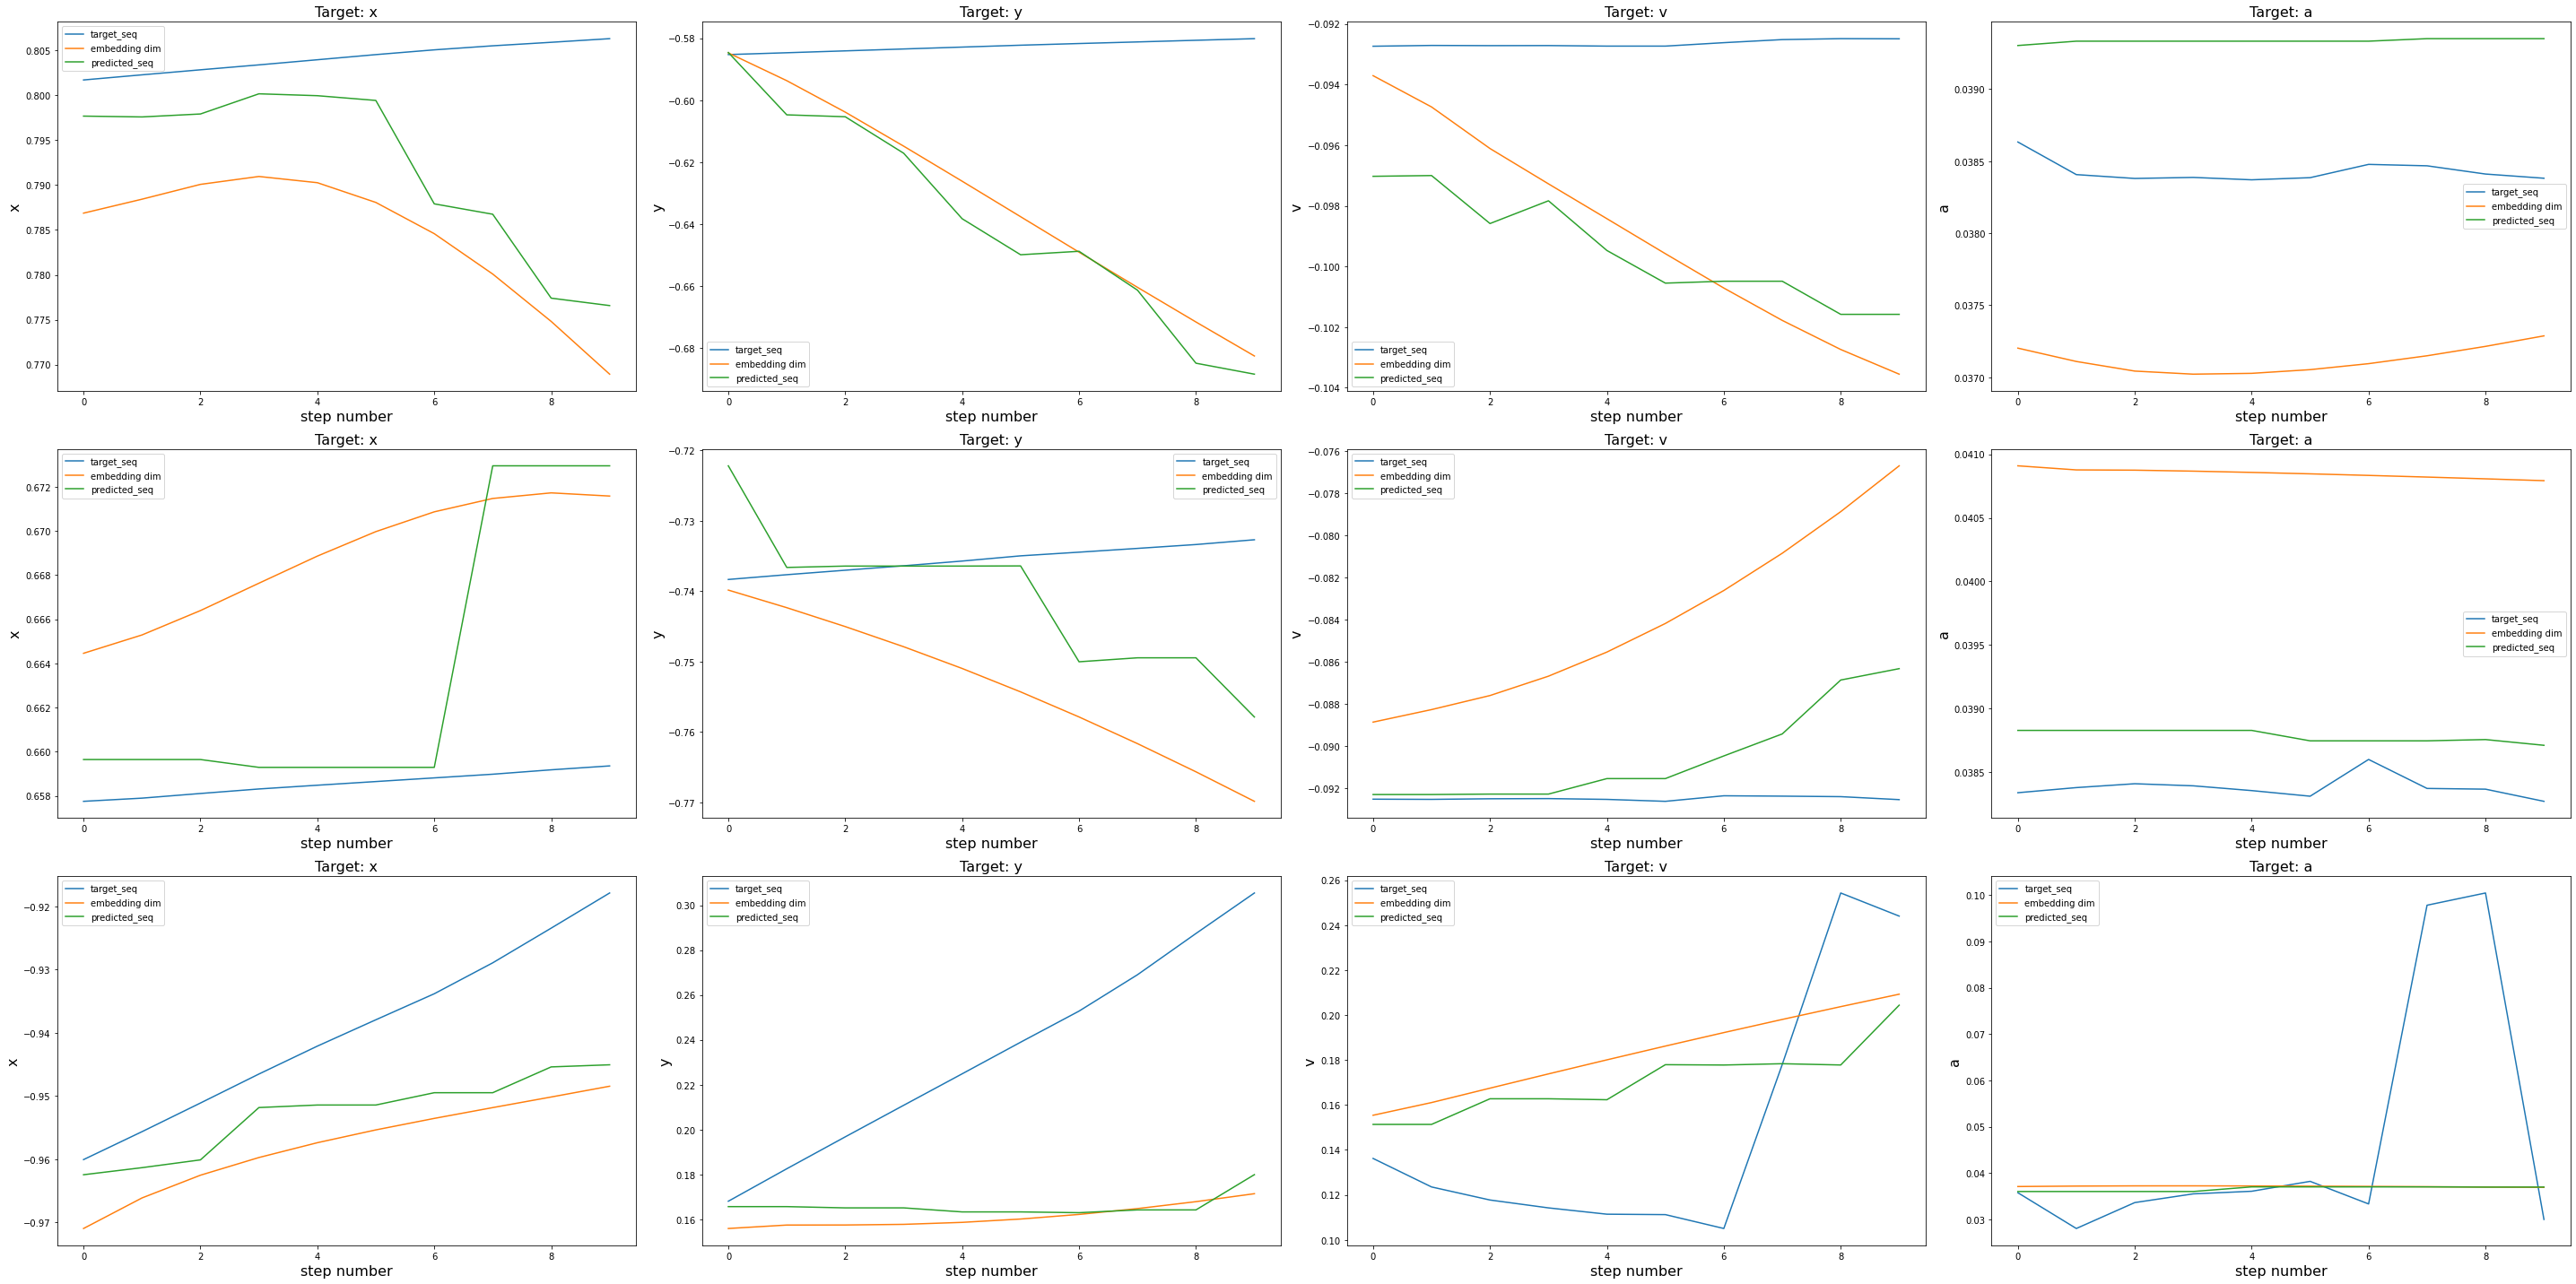

In [44]:
nlstm.eval()
n_samples = 3
n_steps_predict = 10
fresh_start = False

fig, axes = plt.subplots(nrows=n_samples, ncols=len(targets), figsize=(40,20))
r2_scores = defaultdict(list)
for j in range(n_samples):

    start_index = np.random.choice(np.arange(embedding_val.shape[0] - n_steps_predict - dt))
    initial_embedding_seq = embedding_val[start_index:start_index+dt+n_steps_predict] if fresh_start else embedding_val[start_index:start_index+dt]
    target_embedding_seq = embedding_val[start_index+dt:start_index+dt+n_steps_predict].detach().cpu().numpy()
    prev_embedding_seq = np.stack([embedding_val[start_index+dt-1].detach().cpu().numpy() for i in range(n_steps_predict)], 0)

    with torch.no_grad():
        predicted_seq = seq_n_step_predict(nlstm, initial_embedding_seq.unsqueeze(0), n_steps_predict, fresh_start=fresh_start)[0].detach().cpu().numpy()
    for i,(k,v) in enumerate(targets.items()):
        
        target_seq = v[split_index:][start_index+dt:start_index+dt+n_steps_predict]
        preds_prev = np.array([v[split_index:][start_index+dt-1]]*len(target_seq))
        trained_regressors[k].fit(embedding_train.detach().cpu().numpy(), v[:split_index])
        
        preds = trained_regressors[k].predict(predicted_seq)
        preds_prev_embedding = trained_regressors[k].predict(prev_embedding_seq)

        r2_score_model = r2_score(target_seq - preds)
        r2_score_previous = r2_score(target_seq, preds_prev)
        r2_score_previous_emb = r2_score(target_seq, preds_prev_embedding)
        
        r2_scores[k].append([r2_score_model, r2_score_previous, r2_score_previous_emb])
        
        axes[j,i].plot(target_seq, label='target_seq')
        axes[j,i].plot(predicted_seq[:,i], label='embedding dim')
        axes[j,i].plot(preds, label='predicted_seq')
        axes[j,i].set_title(f'Target: {k}', fontsize=16)
        axes[j,i].set_xlabel(f'step number', fontsize=16)
        axes[j,i].set_ylabel(f'{k}', fontsize=16)
        axes[j,i].legend()
plt.tight_layout()
plt.show()

In [45]:
for k,v in r2_scores.items():
    results = np.array(v)
    model, prev, prev_emb = results.mean(0)
    print(f'for {k}', model, prev, prev_emb)

for x -109.60751820959577 -3.553803674770895 -11.566958982006375
for y -545.5665666048022 -3.7761726113934024 -19.740350934302747
for v -2040.317628371596 -5.070108522770117 -438.3935535290487
for a -55.24088687702106 -27.59662512944944 -54.1726399243554


# divergence

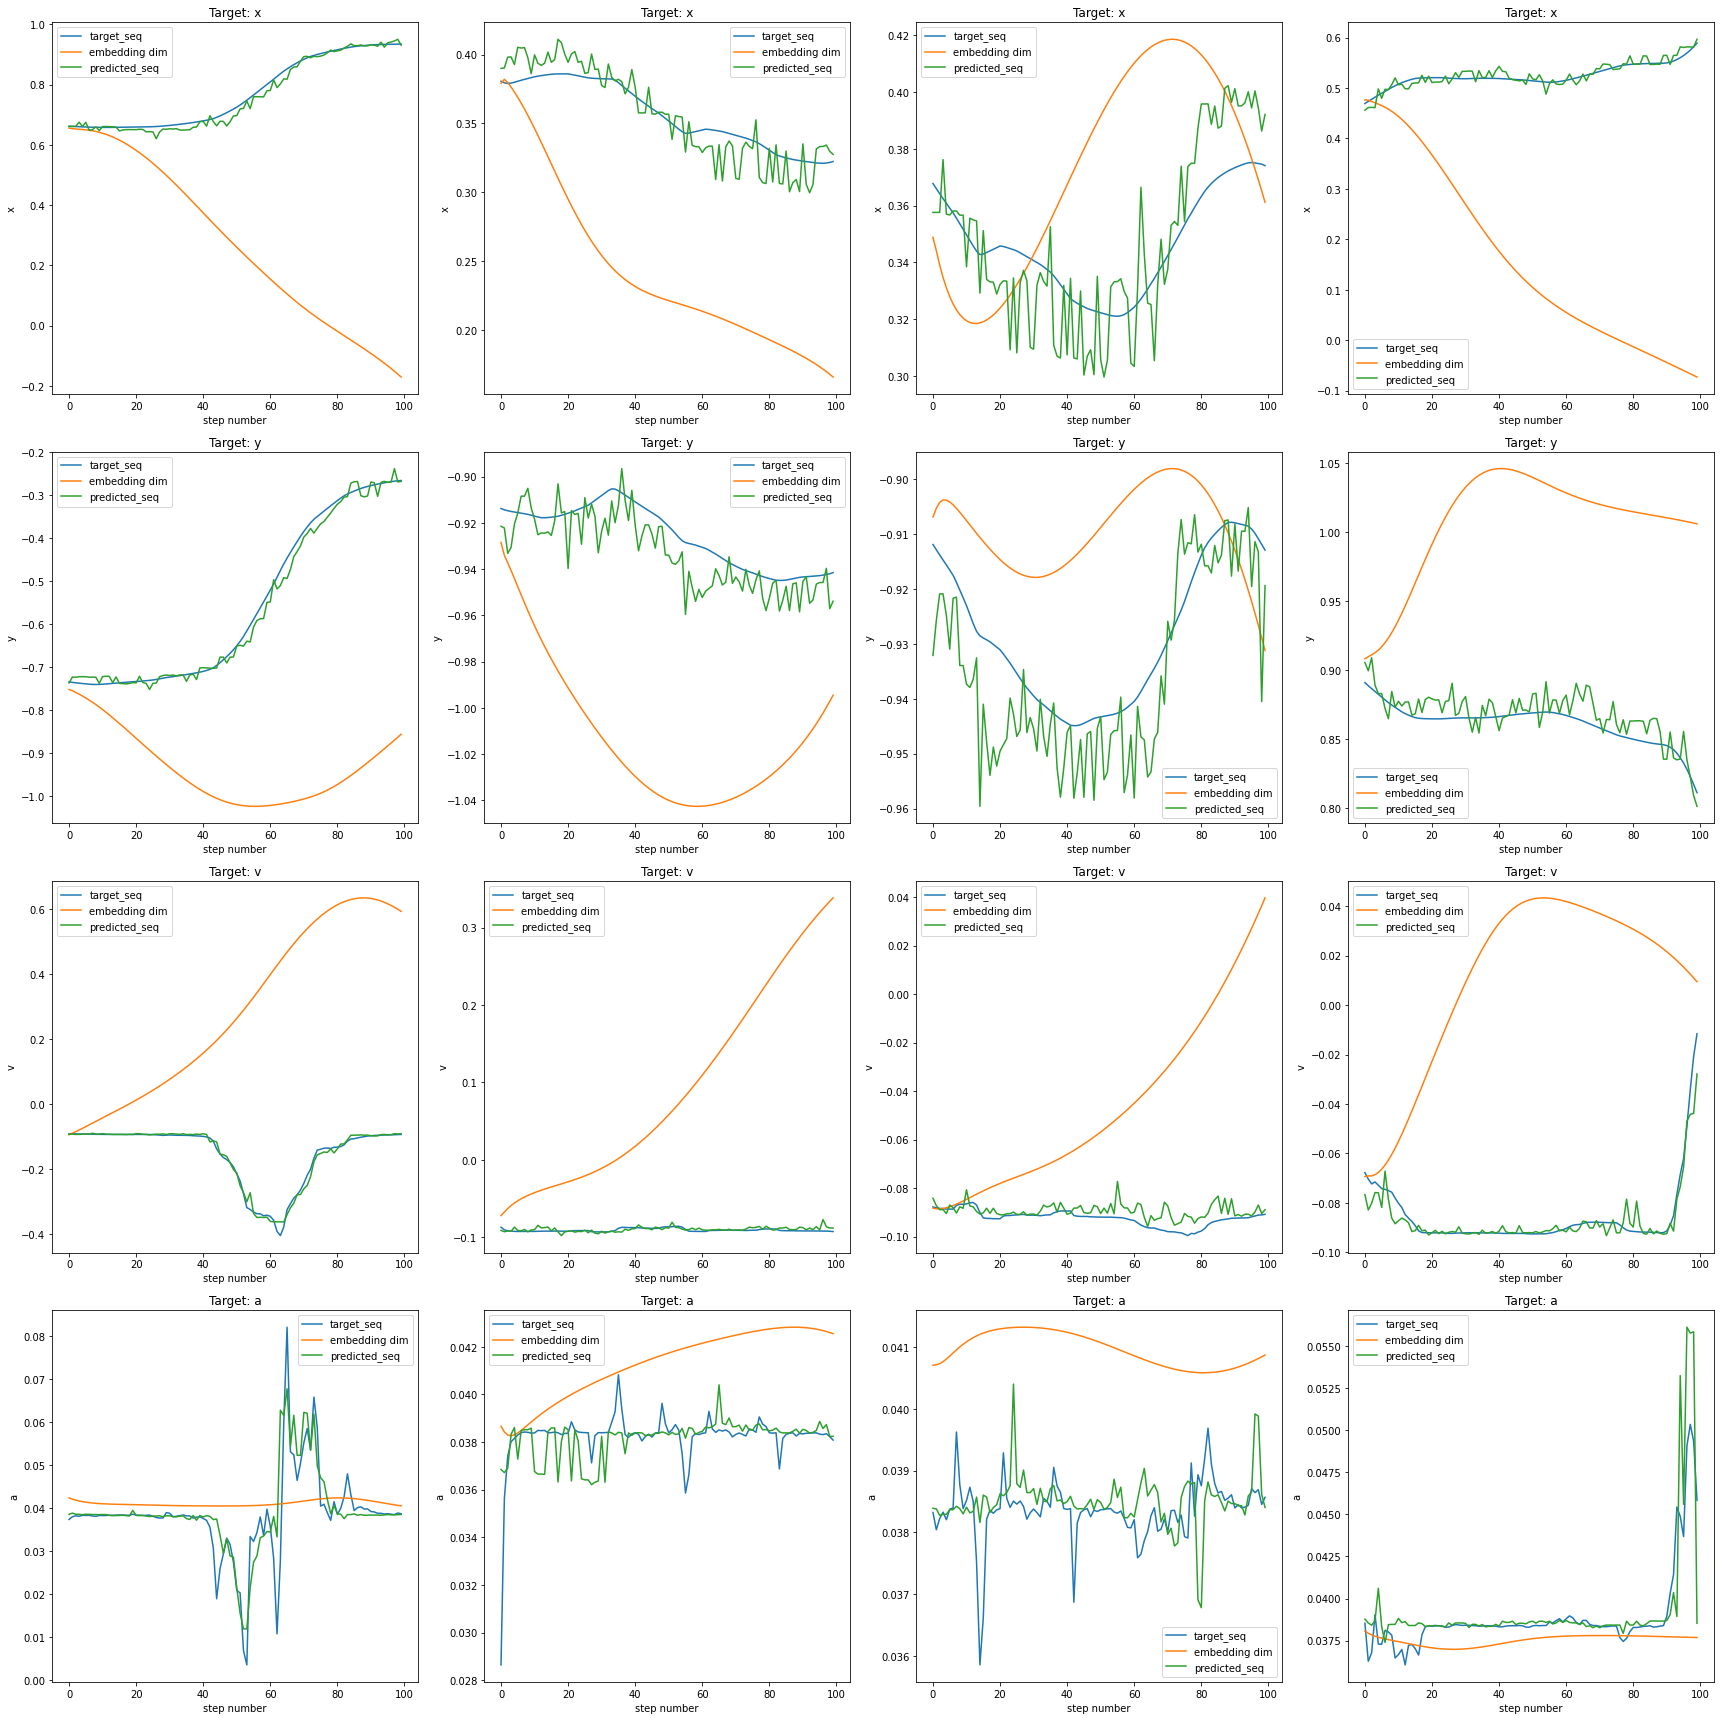

In [26]:
# nlstm.eval()
# n_samples = 4
# fig, axes = plt.subplots(nrows=len(targets), ncols=n_samples, figsize=(24,24))

# for j in range(n_samples):

#     start_index = np.random.choice(np.arange(embedding_val.shape[0] - n_steps_predict - dt))
#     initial_embedding_seq = embedding_val[start_index:start_index+dt]
#     target_embedding_seq = embedding_val[start_index+dt:start_index+dt+n_steps_predict].detach().cpu().numpy()

#     with torch.no_grad():
#         predicted_seq = seq_n_step_predict(nlstm, initial_embedding_seq.unsqueeze(0), n_steps_predict, fresh_start=False)[0].detach().cpu().numpy()
#     for i,(k,v) in enumerate(targets.items()):
        
#         target_seq = v[split_index:][start_index+dt:start_index+dt+n_steps_predict]
#         trained_regressors[k].fit(embedding_train.detach().cpu().numpy(), v[:split_index])
#         preds = trained_regressors[k].predict(target_embedding_seq)
        
#         axes[j,i].plot(target_seq, label='target_seq')
#         axes[j,i].plot(predicted_seq[:,i], label='embedding dim')
#         axes[j,i].plot(preds, label='predicted_seq')
#         axes[j,i].set_title(f'Target: {k}', fontsize=16)
#         axes[j,i].set_xlabel(f'step number', fontsize=16)
#         axes[j,i].set_ylabel(f'{k}', fontsize=16)
#         axes[j,i].legend()
# plt.tight_layout()
# plt.show()